# MACS 40200 Problem Set #3 (Kei Irizawa)

In [1]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

import requests
from IPython.display import Image

# Question 1 (a)

### Structure of Dataset

In [2]:
df = pd.read_csv('data/usincmoms.txt', sep = '\t', header = None, names = ['Percent', 'Midpoint'])
df.index = np.arange(1, len(df)+1)
df.head()

,Percent,Midpoint
1,0.035190,2500
2,0.041062,7500
3,0.058859,12500
4,0.056836,17500
5,0.058595,22500


### Adjustments to data

In [3]:
percent, midpoint = np.loadtxt('data/usincmoms.txt', unpack = True, delimiter = '\t')
data_moment = percent.copy()

In [4]:
midpoint_adj = midpoint.copy() / 1000
weights = percent.copy()
weights[40] = weights[40] / 10
weights[41] = weights[41] / 20
bins = list(np.linspace(0, 200000, num = 41)) + [250000,350000]
bins_adj = list(map(lambda x: x / 1000, bins))

### Histogram

<IPython.core.display.Javascript object>


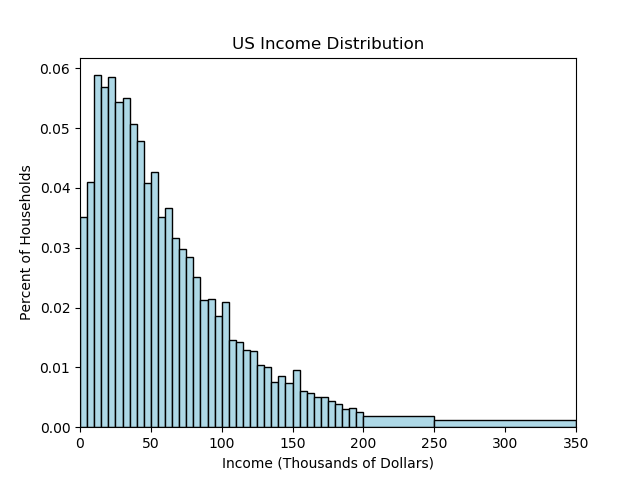

Text(0,0.5,'Percent of Households')

In [5]:
%matplotlib notebook

plt.hist(midpoint_adj, bins = bins_adj, weights = weights, color = 'lightblue', edgecolor = 'k')
plt.xlim([0,350])
plt.title(r'US Income Distribution')
plt.xlabel(r'Income (Thousands of Dollars)')
plt.ylabel(r'Percent of Households')

# Question 1 (b)

The pdf of the lognormal distribution is the following:
$$ \text{(LN):}\quad f(x;\mu,\sigma) = \frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{[\ln(x)-\mu]^2}{2\sigma^2}},\quad x\in(0,\infty), \:\mu\in(-\infty,\infty),\: \sigma>0 $$

### Constructing Criterion Function for the Optimization Problem

In [6]:
def model_moments_lognormal(mu, sigma):

    cdf_lognorm = lambda x: sts.lognorm.cdf(x, s = sigma, scale = np.exp(mu))
    model_mms = []
    
    for i in range(len(bins) - 1):
        model_mms.append(cdf_lognorm(bins[i + 1]) - cdf_lognorm(bins[i]))
 
    model_mms[41] = 1 - cdf_lognorm(bins[41])
    
    return model_mms

In [7]:
def err_vec_lognormal(data, mu, sigma, simple):

    data_mms = data
    model_mms = model_moments_lognormal(mu, sigma)
    
    if simple:
        err_vec = model_mms - data_mms
    else:
        err_vec = (model_mms - data_mms) / data_mms
    
    return err_vec

In [8]:
def criterion_lognormal(params, *args):

    mu, sigma = params
    data, W = args
    
    err = err_vec_lognormal(data, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

### GMM Optimization Problem 

I will guess $\mu_0 = \ln(avg.inc.)$.

In [9]:
avg_income = (midpoint * data_moment).sum()
avg_income

67222.94249

In [10]:
# Initial guess of parameters 
mu_init = np.log(avg_income)
sig_init = 10
params_init = np.array([mu_init, sig_init])

# Weighting matrix 
W_hat = np.diagflat(data_moment)

# Arguments
gmm_args = (data_moment, W_hat)

# Optimization
results_GMM1 = opt.minimize(criterion_lognormal, params_init, args = (gmm_args),
                       method = 'L-BFGS-B', bounds = ((None, None), (1e-10, None)))

mu_GMM1, sig_GMM1 = results_GMM1.x

In [11]:
results_GMM1

      fun: 0.045945282528704244
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.01227923e-08, -1.55361835e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 75
      nit: 12
   status: 0
  success: True
        x: array([10.76684433,  0.90784071])

### GMM Estimates and Minimized Criterion Function Value 

In [12]:
print('Estimates:')
print('mu_GMM =', mu_GMM1) 
print('sig_GMM =', sig_GMM1)
print('Criterion Function =', results_GMM1.fun)

Estimates:
mu_GMM = 10.76684432981201
sig_GMM = 0.907840709278116
Criterion Function = 0.045945282528704244


### Plot

<IPython.core.display.Javascript object>


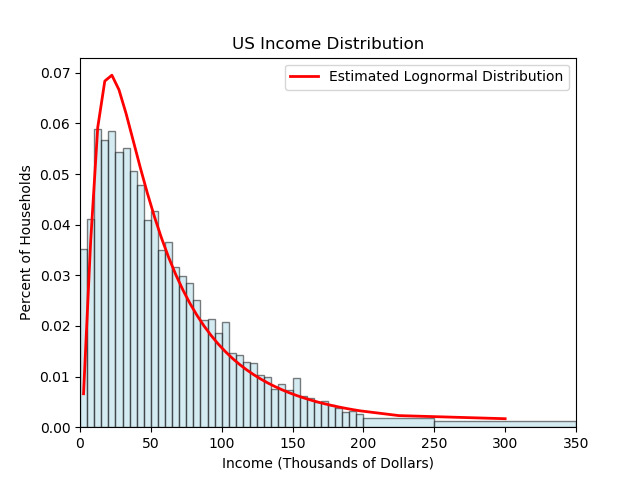

In [13]:
%matplotlib notebook

plt.hist(midpoint_adj, bins = bins_adj, weights = weights, color= 'lightblue', edgecolor = 'k', alpha = 0.5)
plt.xlim([0,350])
plt.title(r'US Income Distribution')
plt.xlabel(r'Income (Thousands of Dollars)')
plt.ylabel(r'Percent of Households')

mms = model_moments_lognormal(mu_GMM1, sig_GMM1)
mms[40] = mms[40] / 10
mms[41] = mms[41] / 20
plt.plot(midpoint_adj, mms, linewidth = 2, color = 'r', label = r'Estimated Lognormal Distribution')
plt.legend(loc='upper right')

# Question 1 (c)

The pdf of the gamma distribution is the following:
$$ \text{(GA):}\quad f(x;\alpha,\beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)}x^{\alpha-1}e^{-\frac{x}{\beta}},\quad x\in[0,\infty), \:\alpha,\beta>0 $$
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$

### Constructing Criterion Function for the Optimization Problem

In [14]:
def model_moments_gamma(alpha, beta):

    cdf_gamma = lambda x: sts.gamma.cdf(x, alpha, loc = 0, scale = beta)
    model_mms = []
    
    for i in range(len(bins) - 1):
        model_mms.append(cdf_gamma(bins[i + 1]) - cdf_gamma(bins[i]))
 
    model_mms[41] = 1 - cdf_gamma(bins[41])
    
    return model_mms

In [15]:
def err_vec_gamma(data, alpha, beta, simple):

    data_mms = data
    model_mms = model_moments_gamma(alpha, beta)
    
    if simple:
        err_vec = model_mms - data_mms
    else:
        err_vec = (model_mms - data_mms) / data_mms
    
    return err_vec

In [16]:
def criterion_gamma(params, *args):

    alpha, beta = params
    data, W = args
    
    err = err_vec_gamma(data, alpha, beta, simple = False)
    crit_val = err.T @ W @ err
    
    return crit_val

### GMM Optimization Problem 

In [17]:
# Initial guess of parameters 
alpha_init = 3
beta_init = 20000
params_init = np.array([alpha_init, beta_init])

# Weighting matrix 
W_hat = np.diagflat(data_moment)

# Arguments
gmm_args = (data_moment, W_hat)

# Optimization
results_GMM2 = opt.minimize(criterion_gamma, params_init, args = (gmm_args),
                       method = 'L-BFGS-B', bounds = ((1e-10, None), (1e-10, None)))

alpha_GMM2, beta_GMM2 = results_GMM2.x

In [18]:
results_GMM2

      fun: 0.012343052077358765
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.76649317e-08, -2.98372438e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 177
      nit: 28
   status: 0
  success: True
        x: array([1.36195299e+00, 4.83549673e+04])

### GMM Estimates and Minimized Criterion Function Value 

In [19]:
print('Estimates')
print('alpha_GMM=', alpha_GMM2)
print('beta_GMM=', beta_GMM2)
print('Criterion Function =', results_GMM2.fun)

Estimates
alpha_GMM= 1.3619529918576738
beta_GMM= 48354.967344263845
Criterion Function = 0.012343052077358765


### Plot

<IPython.core.display.Javascript object>


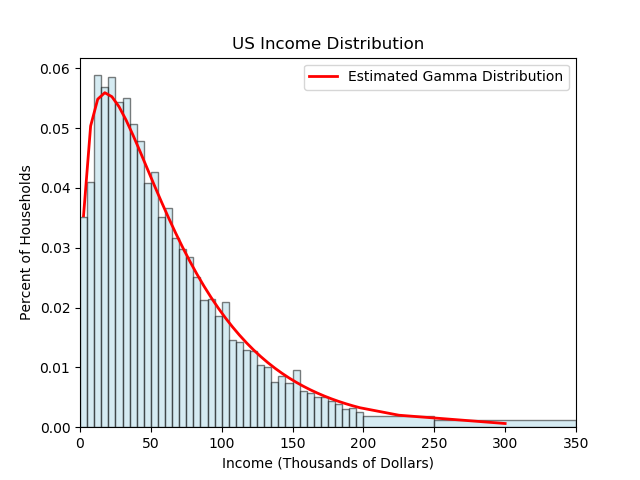

In [20]:
%matplotlib notebook

plt.hist(midpoint_adj, bins = bins_adj, weights = weights, color = 'lightblue', edgecolor = 'k', alpha = 0.5)
plt.xlim([0,350])
plt.title(r'US Income Distribution')
plt.xlabel(r'Income (Thousands of Dollars)')
plt.ylabel(r'Percent of Households')

mms = model_moments_gamma(alpha_GMM2, beta_GMM2)
mms[40] = mms[40] / 10
mms[41] = mms[41] / 20
plt.plot(midpoint_adj, mms,
         linewidth = 2, color = 'r', label = r'Estimated Gamma Distribution')
plt.legend(loc ='upper right')

# Question 1 (d)

<IPython.core.display.Javascript object>


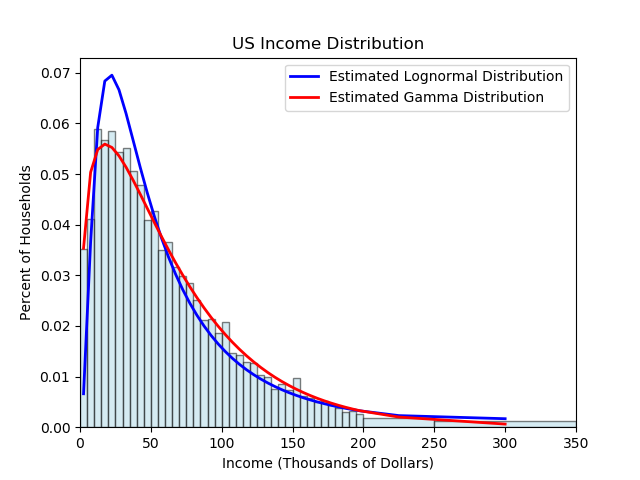

In [21]:
%matplotlib notebook

plt.hist(midpoint_adj, bins = bins_adj, weights = weights, color = 'lightblue', edgecolor = 'k', alpha = 0.5)
plt.xlim([0, 350])
plt.title(r'US Income Distribution')
plt.xlabel(r'Income (Thousands of Dollars)')
plt.ylabel(r'Percent of Households')

mms = model_moments_lognormal(mu_GMM1, sig_GMM1)
mms[40] = mms[40] / 10
mms[41] = mms[41] / 20
plt.plot(midpoint_adj, mms,
         linewidth = 2, color = 'b', label = r'Estimated Lognormal Distribution')
plt.legend(loc='upper right')

mms = model_moments_gamma(alpha_GMM2, beta_GMM2)
mms[40] = mms[40] / 10
mms[41] = mms[41] / 20
plt.plot(midpoint_adj, mms,
         linewidth = 2, color = 'r', label = r'Estimated Gamma Distribution')
plt.legend(loc='upper right')

### Goodness of Fit 

#### Method 1

Since we are using the same moments and weighting matrix for both estimates, we can use the value of the minimized criterion function to compare the goodness of fit. The minimized criterion function values are the following:

In [22]:
print('Lognormal Distribution Minimized Criterion Function =', results_GMM1.fun)
print('Gamma Distribution Minimized Criterion Function =', results_GMM2.fun)

Lognormal Distribution Minimized Criterion Function = 0.045945282528704244
Gamma Distribution Minimized Criterion Function = 0.012343052077358765


Therefore, the minimized criterion function values indicate that the Gamma distribution has a better goodness of fit. In fact, when we eyeball the graph, it seems to be the case that the Gamma distribution has a better goodness of fit. 

#### Method 2

We can also test model adequacy by using the Hansen-Sargan overidentification test statistics (J-Test). We have an overidentified model with l > k, where l is the number of moment conditions (42) and k is the number of parameters (2).

Under the null hypothesis that: $E(e(x|\theta)) = 0$ or correct model specification:

$$ J = \frac{1}{N} \times e(x|\hat\theta_{GMM})^T \, \hat{W} \, e(x|\hat\theta_{GMM}) \overset{d}{\rightarrow} \chi^2_{(l-k)}$$

In our case, we have m = 41 and k = 2 so,

$$ J = \frac{1}{N} \times e(x|\hat\theta_{GMM})^T \, \hat{W} \, e(x|\hat\theta_{GMM}) \overset{d}{\rightarrow} \chi^2_{(40)}$$

In [23]:
def p_val(J_score, n):
 
    pval = 1.0 - sts.chi2.cdf(J_score, n)
    
    return pval

#### J-Test for Lognormal Distribution

In [24]:
J_score = 1 / 42 * results_GMM1.fun
degree_freedom = 40
print('J Test Score = ', J_score)
print('Chi squared p-value = ', p_val(J_score, degree_freedom))

J Test Score =  0.001093935298302482
Chi squared p-value =  1.0


#### J-Test for Gamma Distribution

In [25]:
J_score = 1 / 42 * results_GMM2.fun
degree_freedom = 40
print('J Test Score = ', J_score)
print('Chi squared p-value = ', p_val(J_score, degree_freedom))

J Test Score =  0.00029388219231806585
Chi squared p-value =  1.0


#### Interpretation

We have a p-value of about 1 for both J-test. We can interet the p-value as: if the null hypothesis is true, discrepancies this large or larger would be expected to occur on the basis of chance about 100% of the time. Therefore, we cannot reject the null hypothesis.  

# Question 2 (a)

Data on ($c_t, k_t, w_t, r_t$) are given. We will use the following set of equations for estimation: 

\begin{equation} \tag{1}
(c_t)^{-1} -\beta E[r_{t+1}(c_{t+1})^{-1}] = 0  
\end{equation}

\begin{equation} \tag{2}
c_t+ k_{t+1} - w_t - r_tk_t = 0 \quad 
\end{equation}

\begin{equation} \tag{3}
w_t-(1-\alpha)(e)^{z_t}(k_t)^\alpha = 0 \quad 
\end{equation}

\begin{equation} \tag{4}
r_t - \alpha (e)^{z_t}(k_t)^{\alpha-1} =0 \quad 
\end{equation}

\begin{equation} \tag{5}
z_t = \rho z_{t-1} + (1-\rho)\mu + \epsilon_t \\
\mbox{where }E[\epsilon_t] = 0 
\end{equation}



### Data Structure

In [26]:
data = np.loadtxt('data/MacroSeries.txt', delimiter = ',')
df = pd.DataFrame(data, columns = ['ct', 'kt', 'wt', 'rt'])
df.head()

,ct,kt,wt,rt
0,1.067109e+07,8.040697e+06,1.059438e+07,0.954120
1,1.169487e+07,7.595072e+06,1.161079e+07,1.107009
2,9.292394e+06,8.323735e+06,9.225588e+06,0.802596
3,7.913165e+06,6.613792e+06,7.856274e+06,0.860176
4,8.140994e+06,5.632136e+06,8.082466e+06,1.039183


In [27]:
ct, kt, wt, rt = np.loadtxt('data/MacroSeries.txt', unpack = True, delimiter = ",")

### Approach

We will be using the unconditional moment conditions that $E[\epsilon_t]=0$ and $E[\beta r_{t+1} c_t / c_{t+1} - 1] = 0$. (Assume $\beta = 0.99$). Therefore, we will use the following four moment conditions to estimate the three parameters:

\begin{equation} \tag{6}
E[z_{t+1} - \rho z_{t} - (1 - \rho) \mu] = 0 
\end{equation}

\begin{equation} \tag{7}
E[(z_{t+1} - \rho z_{t} - (1 - \rho) \mu) z_t] = 0
\end{equation}

\begin{equation} \tag{8}
E[\beta \alpha e^{z_t+1} k^{\alpha-1}_{t+1} \frac{c_t}{c_{t+1}} - 1] = 0 
\end{equation}

\begin{equation} \tag{9}
E[(\beta \alpha e^{z_t+1} k^{\alpha-1}_{t+1} \frac{c_t}{c_{t+1}} - 1) w_t] = 0 
\end{equation}

The estimation inside each iteration of the minimizer of the GMM objective function is the following:

Step 1) Given a guess for ($\alpha, \rho, \mu$) and data ($c_t, k_t, w_t, r_t$), use (4) to back out an implied series for $z_t$.

Step 2) Given $z_t$, parameters ($\alpha, \rho, \mu$) and data ($c_t, k_t, w_t, r_t$), calculate four empirical analogues of the moment conditions (6), (7), (8), (9).

Step 3) Update guesses for parameter values ($\alpha, \rho, \mu$) until minimum criterion value is found.

### Sequence of Zt from data and equation (4)

$$ r_t = \alpha\exp(z_t)(k_t)^{\alpha-1} $$

$$\Leftrightarrow z_t = \log(r_t) - \log(\alpha)-(\alpha-1)\log(k_t)$$

In [28]:
def seq_zt(rt, kt, alpha):

    zt = np.log(rt) - np.log(alpha) - (alpha - 1) * np.log(kt)
    
    return zt

### Constructing Criterion Function for the Optimization Problem

To find the data moments, we need to calculate four empirical analogues of the moment conditions (6), (7), (8), (9).

\begin{equation} \tag{Analogue of 6}
\frac{1}{N} \sum_{t=1}^{N} [z_{t+1} - \rho z_{t} - (1 - \rho) \mu]
\end{equation}

\begin{equation} \tag{Analogue of 7}
\frac{1}{N} \sum_{t=1}^{N}[(z_{t+1} - \rho z_{t} - (1 - \rho) \mu) z_t] 
\end{equation}

\begin{equation} \tag{Analogue of 8}
\frac{1}{N} \sum_{t=1}^{N}[\beta \alpha e^{z_t+1} k^{\alpha-1}_{t+1} \frac{c_t}{c_{t+1}} - 1] 
\end{equation}

\begin{equation} \tag{Analogue of 9}
\frac{1}{N} \sum_{t=1}^{N}[(\beta \alpha e^{z_t+1} k^{\alpha-1}_{t+1} \frac{c_t}{c_{t+1}} - 1) w_t] 
\end{equation}

In [29]:
def data_moments(params, args):

    beta = 0.99  # assumption
    rt, kt, ct, wt = args
    alpha, rho, mu = params
    
    zt = seq_zt(rt, kt, alpha)
    
    zt_1 = zt[1:]  # refers to z_{t+1}
    kt_1 = kt[1:]  # refers to k_{t+1}
    ct_1 = ct[1:]  # refers to c_{t+1}
    
    # If we take [1:] to find the period (t+1) values like above, we lose one data value, so we have to adjust:
    zt = zt[:-1]
    rt = rt[:-1]
    kt = kt[:-1] 
    ct = ct[:-1]
    wt = wt[:-1]
        
    mm1 = zt_1 - rho * zt - (1 - rho) * mu
    mm2 = (zt_1 - rho * zt - (1 - rho) * mu) * zt
    mm3 = beta * alpha * np.exp(zt_1) * kt_1 ** (alpha - 1) * ct / ct_1 - 1
    mm4 = (beta * alpha * np.exp(zt_1) * kt_1 ** (alpha - 1) * ct / ct_1 - 1) * wt
        
    mm1 = sum(mm1) / len(mm1)
    mm2 = sum(mm2) / len(mm2)
    mm3 = sum(mm3) / len(mm3)
    mm4 = sum(mm4) / len(mm4)
    
    return mm1, mm2, mm3, mm4

In [30]:
def err_vec(params, args, simple=False):
    
    mm1, mm2, mm3, mm4 = data_moments(params, args)
    data_moms = np.array([mm1, mm2, mm3, mm4])
    model_moms = np.array([0, 0, 0, 0])
    
    if simple:
        err_vec = model_moms - data_moms
    else:
        err_vec = (model_moms - data_moms) / data_moms
    
    return err_vec

In [31]:
def criterion(params, *args):
    
    alpha, rho, mu = params
    rt, kt, ct, wt, W = args 
    
    err = err_vec(params, args[:-1], simple=True)
    crit_val = err.T @ W @ err
    
    return crit_val

### GMM Optimization Problem 

In [32]:
# initial guess of parameters
alpha_0 = 0.5
rho_0 = 0.85
mu_0 = 10
params_init = np.array([alpha_0, rho_0, mu_0])

W_hat = np.eye(4)
GMM_args = (rt, kt, ct, wt, W_hat)

bnds = ((1e-10, 1-1e-10), (-1+1e-10, 1-1e-10), (1e-10, None))

# implement optimization
results_GMM3 = opt.minimize(criterion, params_init, args = (GMM_args), tol = 1e-14,
                           bounds = bnds, method = 'L-BFGS-B')
    
alpha_GMM3, rho_GMM3, mu_GMM3 = results_GMM3.x

In [33]:
results_GMM3

      fun: 2.608915445370338e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.14853564e-03,  5.24060424e-06, -1.18728762e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 988
      nit: 48
   status: 0
  success: True
        x: array([0.42410452, 0.82875887, 9.978308  ])

### GMM Estimates and Minimized Criterion Function Value 

In [34]:
print('Estimates')
print('alpha_GMM=', alpha_GMM3)
print('rho_GMM=', rho_GMM3)
print('mu_GMM=', mu_GMM3)
print('Criterion Function =', results_GMM3.fun)

Estimates
alpha_GMM= 0.42410452456022835
rho_GMM= 0.8287588735566751
mu_GMM= 9.978308003318212
Criterion Function = 2.608915445370338e-08


In [35]:
params_GMM = np.array([alpha_GMM3, rho_GMM3, mu_GMM3])
args_GMM = (rt, kt, ct, wt)
print('Data Moments =', data_moments(params_GMM, args_GMM))
print('Model Moments =', (0,0,0,0))
print('Error Vector =', err_vec(params_GMM, args_GMM, simple=True))

Data Moments = (0.00016043656358356932, 1.8688593289419425e-05, -1.0092936587501423e-17, -2.477203349109124e-10)
Model Moments = (0, 0, 0, 0)
Error Vector = [-1.60436564e-04 -1.86885933e-05  1.00929366e-17  2.47720335e-10]
